In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from local_explanations import *
import utils
import models
import json

import matplotlib.pyplot as plt
import torch
import torch_geometric.transforms as T

%load_ext autoreload
%autoreload 2

## Read hyper-parameters and data

In [2]:
DATASET_NAME = "Mutagenicity"

with open("../config/" + DATASET_NAME + "_params.json") as json_file:
    hyper_params = json.load(json_file)

user = "author"
if user == "author":
    SAVE_GLG_MODEL_PATH = "../trained_models/mutagenicity_with_nh2_samele.pt"
    manual_cut = hyper_params["manual_cut"]
else:
    SAVE_GLG_MODEL_PATH = "../our_data/trained_models/mutagenicity_with_nh2.pt"
    manual_cut = None # Armgaan: Our explanations have smaller values than the authors'

In [3]:
from local_explanations import read_mutagenicity


adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_mutagenicity(evaluate_method=False, 
                                     manual_cut=manual_cut,
                                     split="TRAIN")

In [4]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=manual_cut,
                                   split="VAL")

In [5]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_mutagenicity(evaluate_method=False, 
                                    manual_cut=manual_cut,
                                    split="TEST")

In [6]:
device = "cpu" # torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None

#  ERROR : adjs_train is empty. 
dataset_train = utils.LocalExplanationsDataset("", adjs_train, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val   = utils.LocalExplanationsDataset("", adjs_val,   "embeddings", transform=transform, y=le_classes_val,   belonging=belonging_val,   task_y=ori_classes_val,   precomputed_embeddings=embeddings_val)
dataset_test  = utils.LocalExplanationsDataset("", adjs_test,  "embeddings", transform=transform, y=le_classes_test,  belonging=belonging_test,  task_y=ori_classes_test,  precomputed_embeddings=embeddings_test)

/DATATWO/users/burouj/code/github/glgexplainer/code/utils.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


In [7]:
dataset_train[0]
# y: le_class created through isomorphism tests.
# task_y: gnn prediction
# le_id: A connected component's id
# graph_id: Graph id of the graph to which the connected component belongs.

Data(x=[3, 14], edge_index=[2, 4], edge_attr=[4, 1], y=[1], task_y=[1], le_id=[1], graph_id=[1], num_nodes=3)

## Train GLGExplainer

In [8]:
train_group_loader = utils.build_dataloader(dataset_train, belonging_train, num_input_graphs=128)
val_group_loader   = utils.build_dataloader(dataset_val,   belonging_val,   num_input_graphs=256)
test_group_loader  = utils.build_dataloader(dataset_test,  belonging_test,  num_input_graphs=256)

torch.manual_seed(42)

# Computes the graph embedding of single, disconnected local explanations.
le_model = models.LEEmbedder(
    num_features=hyper_params["num_le_features"], 
    activation=hyper_params["activation"], 
    num_hidden=hyper_params["dim_prototypes"]
).to(device)

# e-len model. Generates the truth table.
len_model = models.LEN(
    hyper_params["num_prototypes"], 
    hyper_params["LEN_temperature"], 
    remove_attention=hyper_params["remove_attention"]
).to(device)

expl = models.GLGExplainer(
    len_model, 
    le_model, 
    device, 
    hyper_params=hyper_params,
    classes_names=mutag_classes_names, # So, the class names are "NO2 & others" rather than "mutagenic & non-mutagenic"?
    dataset_name=DATASET_NAME,
    num_classes=len(train_group_loader.dataset.data.task_y.unique()) # This is not safe.
).to(device)

/DATATWO/users/burouj/miniconda3/envs/glg/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


(array([0., 1.], dtype=float32), array([   2, 5921]))
[0.91339314 0.06659512]


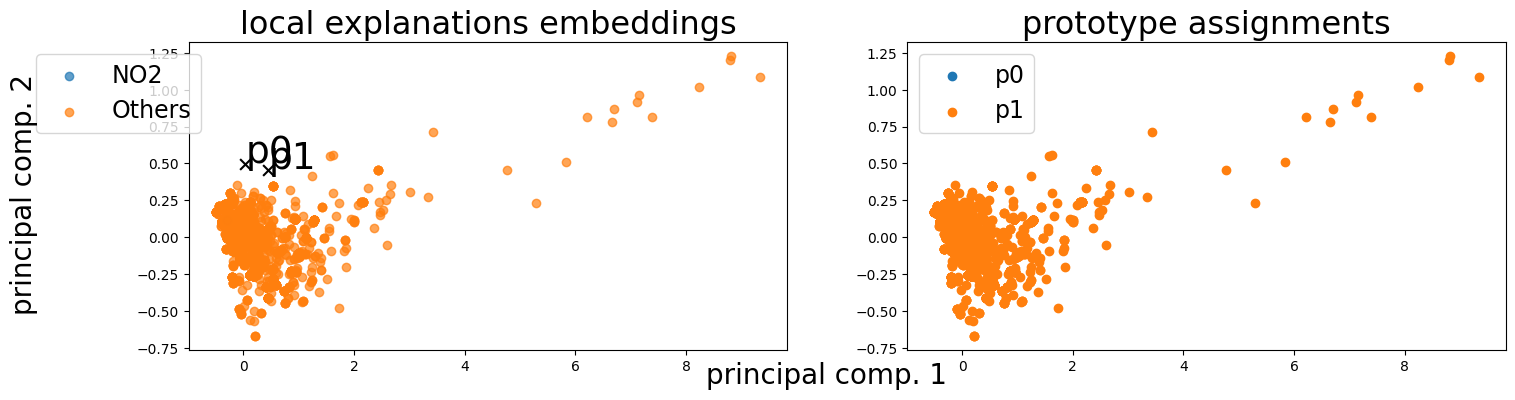

Alpha norms:
tensor([[1.0000, 0.9533],
        [0.9588, 1.0000]])
Concept Purity: 0.999662 +- 0.000000
Concept distribution:  (array([1]), array([5923]))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.)

  1 | Train Acc: 0.00, Train Loss: 0.10843, Train LEN loss: 0.052509, | Val Acc: 0.00, Val Loss: 0.10857, Val LEN loss: 0.060
  2 | Train Acc: 0.00, Train Loss: 0.07095, Train LEN loss: 0.051411, | Val Acc: 0.00, Val Loss: 0.06766, Val LEN loss: 0.059
  3 | Train Acc: 0.00, Train Loss: 0.05560, Train LEN loss: 0.050760, | Val Acc: 0.00, Val Loss: 0.06114, Val LEN loss: 0.059
  4 | Train Acc: 0.00, Train Loss: 0.05237, Train LEN loss: 0.050463, | Val Acc: 0.00, Val Loss: 0.06015, Val LEN loss: 0.058
  5 | Train Acc: 0.00, Train Loss: 0.05180, Train LEN loss: 0.050232, | Val Acc: 0.00, Val Loss: 0.05970, Val LEN loss: 0.058
  6 | Train Acc: 0.00, Train Loss: 0.05174, Train LEN loss: 0.049995, | Val Acc: 0.00, Val Loss: 0.05973

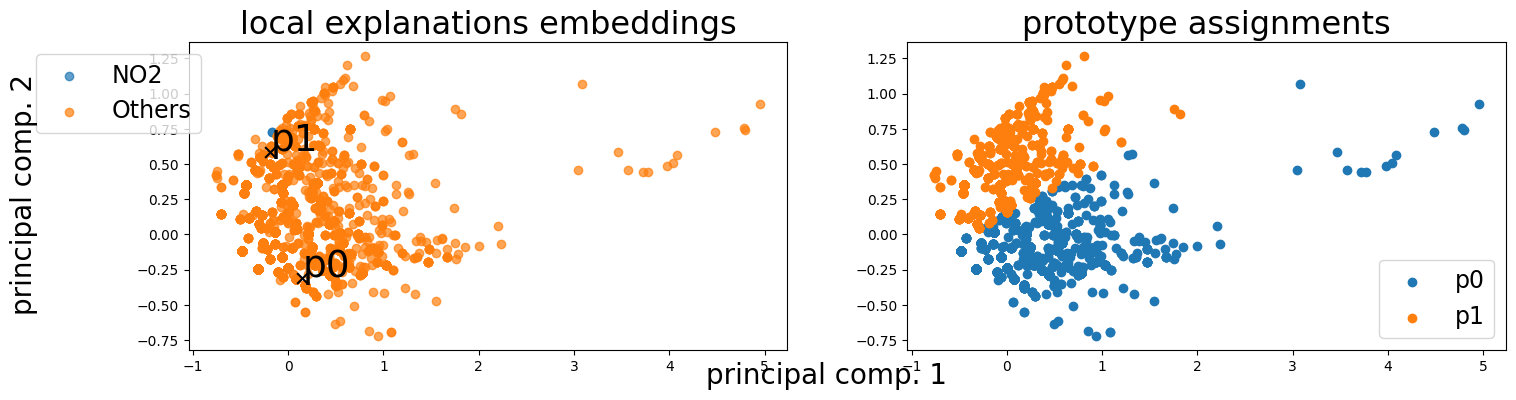

Alpha norms:
tensor([[0.8045, 1.0000],
        [1.0000, 0.7984]])
Concept Purity: 0.999277 +- 0.000723
Concept distribution:  (array([0, 1]), array([4539, 1384]))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.5517241379310345 ((feature0000000001)
Accuracy as classifier:  0.0
LEN fidelity:  tensor(0.4612)


 20 | Train Acc: 0.47, Train Loss: 0.05021, Train LEN loss: 0.049122, | Val Acc: 0.48, Val Loss: 0.05798, Val LEN loss: 0.057
 21 | Train Acc: 0.46, Train Loss: 0.05009, Train LEN loss: 0.049374, | Val Acc: 0.51, Val Loss: 0.05764, Val LEN loss: 0.057
 22 | Train Acc: 0.49, Train Loss: 0.04983, Train LEN loss: 0.049187, | Val Acc: 0.48, Val Loss: 0.05754, Val LEN loss: 0.057
 23 | Train Acc: 0.48, Train Loss: 0.04967, Train LEN loss: 0.049220, | Val Acc: 0.48, Val Loss: 0.05750, Val LEN loss: 0.057
 24 | Train Acc: 0.47, Train Loss: 0.05020, Train LEN loss: 0.049293, | Val Acc: 0.50, Val Loss: 0.05729, Val LEN loss: 0.057
 25 | Train Acc: 0.48, Train Loss: 0.04972, Train LEN los

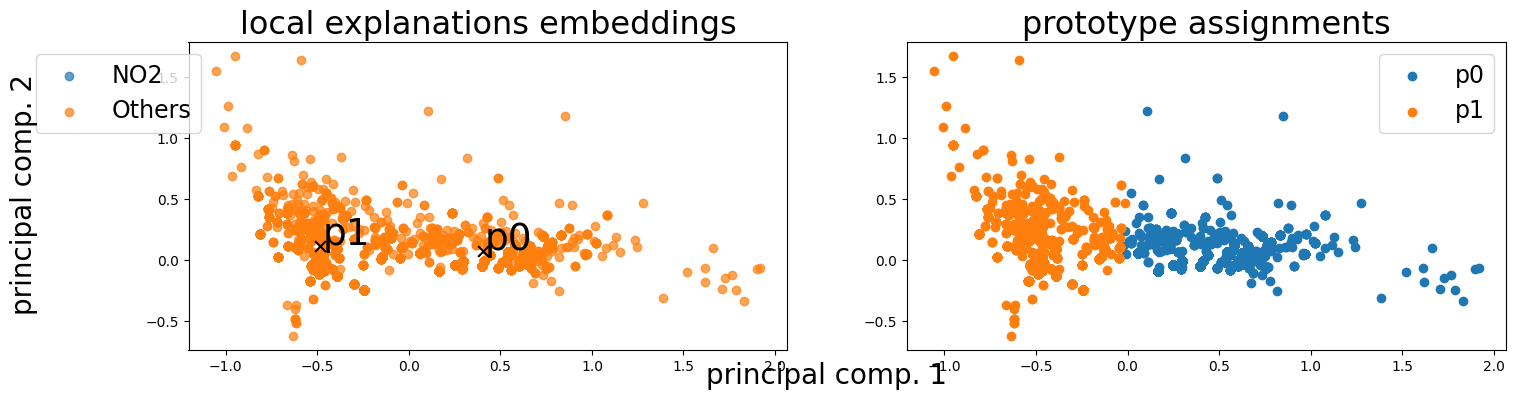

Alpha norms:
tensor([[1.0000, 0.7722],
        [1.0000, 0.6881]])
Concept Purity: 0.999659 +- 0.000341
Concept distribution:  (array([0, 1]), array([2990, 2933]))
Logic formulas:
For class 0:
0.6230884557721139 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6230884557721139 ((feature0000000001)
Accuracy as classifier:  0.6231
LEN fidelity:  tensor(0.6231)


 40 | Train Acc: 0.62, Train Loss: 0.04812, Train LEN loss: 0.047822, | Val Acc: 0.64, Val Loss: 0.05526, Val LEN loss: 0.055
 41 | Train Acc: 0.62, Train Loss: 0.04797, Train LEN loss: 0.047706, | Val Acc: 0.64, Val Loss: 0.05541, Val LEN loss: 0.055
 42 | Train Acc: 0.62, Train Loss: 0.04823, Train LEN loss: 0.048026, | Val Acc: 0.64, Val Loss: 0.05547, Val LEN loss: 0.055
 43 | Train Acc: 0.62, Train Loss: 0.04793, Train LEN loss: 0.047712, | Val Acc: 0.65, Val Loss: 0.05525, Val LEN loss: 0.055
 44 | Train Acc: 0.63, Train Loss: 0.04830, Train LEN loss: 0.047963, | Val Acc: 0.64, Val Loss: 0.05517,

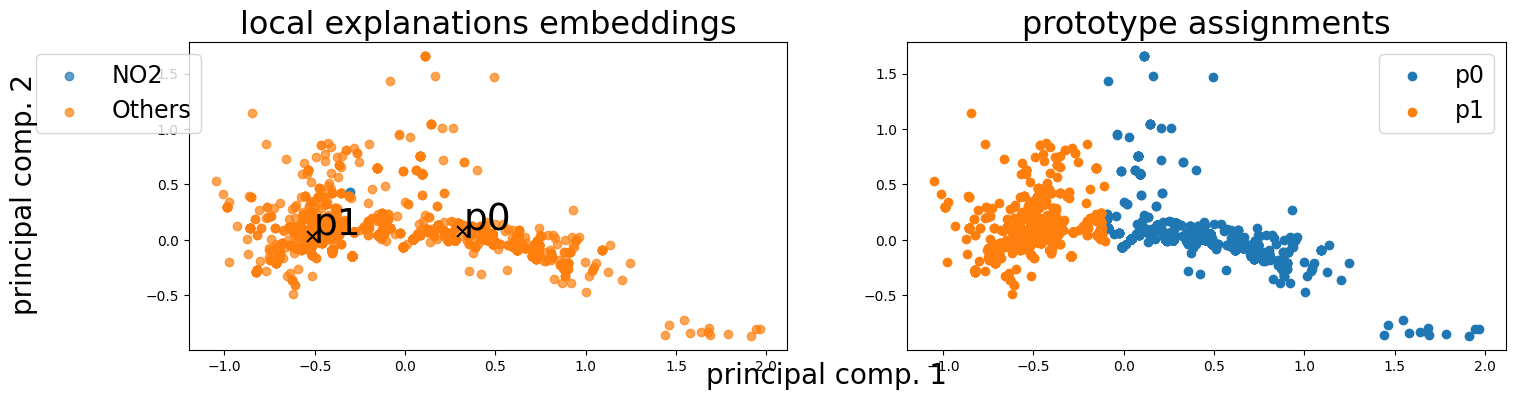

Alpha norms:
tensor([[1.0000, 0.5776],
        [1.0000, 0.5718]])
Concept Purity: 0.999641 +- 0.000359
Concept distribution:  (array([0, 1]), array([3140, 2783]))
Logic formulas:
For class 0:
0.6374812593703149 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6374812593703149 ((feature0000000001)
Accuracy as classifier:  0.6375
LEN fidelity:  tensor(0.6375)


 60 | Train Acc: 0.64, Train Loss: 0.04731, Train LEN loss: 0.047120, | Val Acc: 0.66, Val Loss: 0.05484, Val LEN loss: 0.054
 61 | Train Acc: 0.64, Train Loss: 0.04722, Train LEN loss: 0.047023, | Val Acc: 0.66, Val Loss: 0.05386, Val LEN loss: 0.053
 62 | Train Acc: 0.64, Train Loss: 0.04751, Train LEN loss: 0.047333, | Val Acc: 0.66, Val Loss: 0.05445, Val LEN loss: 0.054
 63 | Train Acc: 0.64, Train Loss: 0.04770, Train LEN loss: 0.047492, | Val Acc: 0.66, Val Loss: 0.05429, Val LEN loss: 0.054
 64 | Train Acc: 0.64, Train Loss: 0.04732, Train LEN loss: 0.047127, | Val Acc: 0.66, Val Loss: 0.05459,

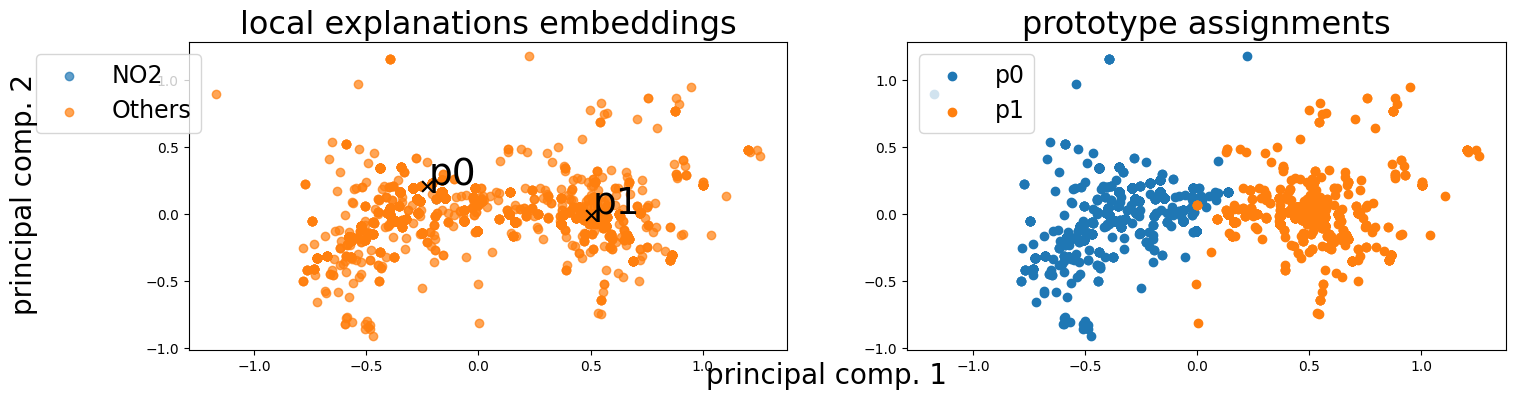

Alpha norms:
tensor([[1.0000, 0.6141],
        [1.0000, 0.5876]])
Concept Purity: 0.999694 +- 0.000306
Concept distribution:  (array([0, 1]), array([3266, 2657]))
Logic formulas:
For class 0:
0.6428785607196402 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6428785607196402 ((feature0000000001)
Accuracy as classifier:  0.6429
LEN fidelity:  tensor(0.6429)


 80 | Train Acc: 0.63, Train Loss: 0.04768, Train LEN loss: 0.047538, | Val Acc: 0.67, Val Loss: 0.05427, Val LEN loss: 0.054
 81 | Train Acc: 0.64, Train Loss: 0.04755, Train LEN loss: 0.047106, | Val Acc: 0.66, Val Loss: 0.05442, Val LEN loss: 0.054
 82 | Train Acc: 0.63, Train Loss: 0.04754, Train LEN loss: 0.047355, | Val Acc: 0.65, Val Loss: 0.05345, Val LEN loss: 0.053
 83 | Train Acc: 0.63, Train Loss: 0.04762, Train LEN loss: 0.047412, | Val Acc: 0.66, Val Loss: 0.05459, Val LEN loss: 0.054
 84 | Train Acc: 0.63, Train Loss: 0.04716, Train LEN loss: 0.046997, | Val Acc: 0.66, Val Loss: 0.05454,

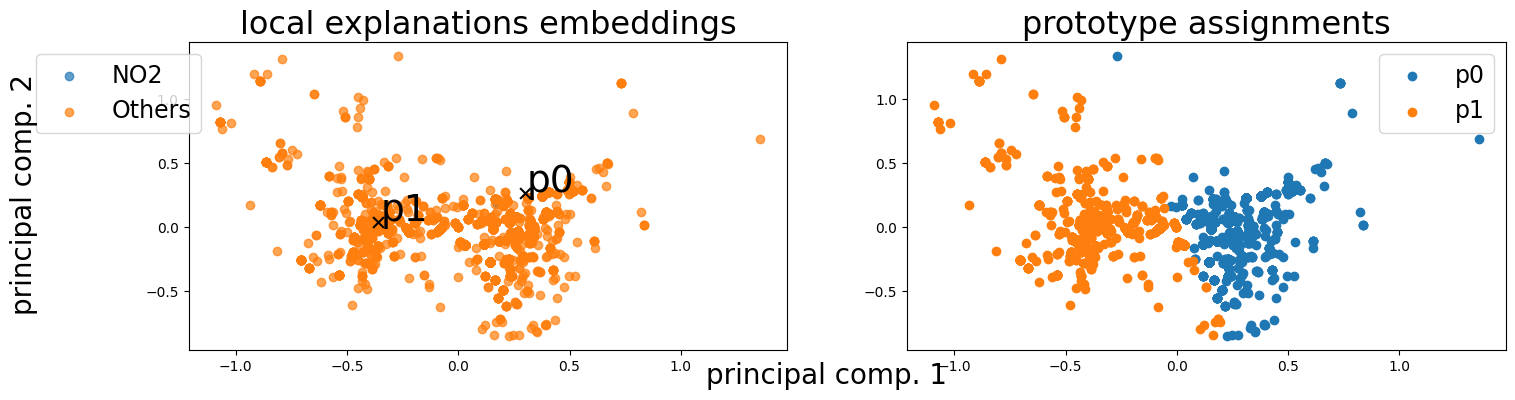

Alpha norms:
tensor([[1.0000, 0.5714],
        [1.0000, 0.5552]])
Concept Purity: 0.999676 +- 0.000324
Concept distribution:  (array([0, 1]), array([3091, 2832]))
Logic formulas:
For class 0:
0.6410794602698651 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6410794602698651 ((feature0000000001)
Accuracy as classifier:  0.6411
LEN fidelity:  tensor(0.6411)


100 | Train Acc: 0.64, Train Loss: 0.04734, Train LEN loss: 0.047134, | Val Acc: 0.66, Val Loss: 0.05396, Val LEN loss: 0.054
101 | Train Acc: 0.64, Train Loss: 0.04782, Train LEN loss: 0.047656, | Val Acc: 0.67, Val Loss: 0.05398, Val LEN loss: 0.054
102 | Train Acc: 0.64, Train Loss: 0.04726, Train LEN loss: 0.047113, | Val Acc: 0.67, Val Loss: 0.05373, Val LEN loss: 0.053
103 | Train Acc: 0.64, Train Loss: 0.04772, Train LEN loss: 0.047588, | Val Acc: 0.67, Val Loss: 0.05315, Val LEN loss: 0.053
104 | Train Acc: 0.64, Train Loss: 0.04730, Train LEN loss: 0.047123, | Val Acc: 0.67, Val Loss: 0.05399,

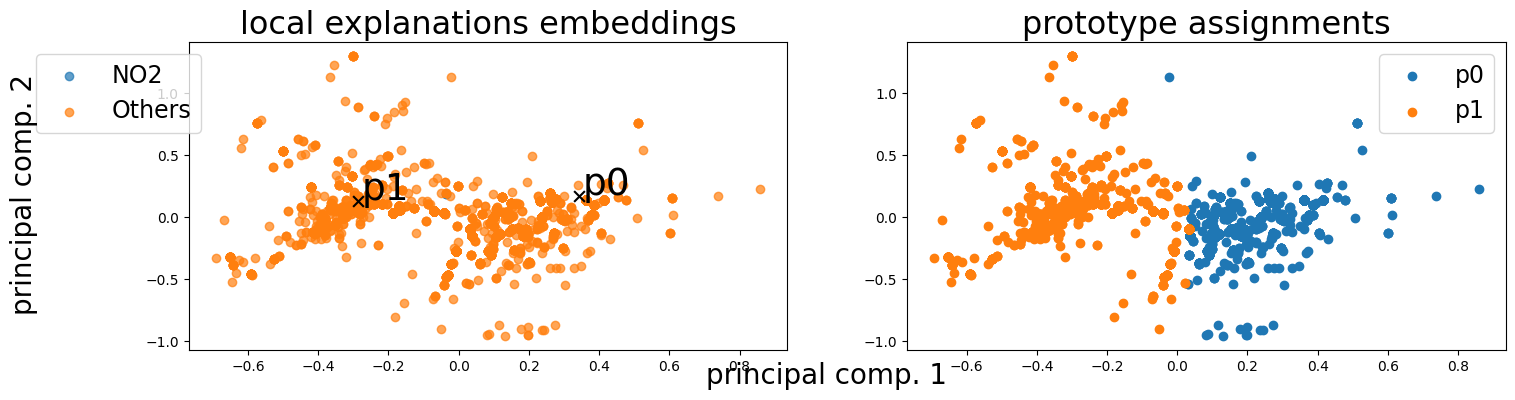

Alpha norms:
tensor([[1.0000, 0.5649],
        [1.0000, 0.5494]])
Concept Purity: 0.999681 +- 0.000319
Concept distribution:  (array([0, 1]), array([2785, 3138]))
Logic formulas:
For class 0:
0.6443778110944528 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6443778110944528 ((feature0000000001)
Accuracy as classifier:  0.6444
LEN fidelity:  tensor(0.6444)


120 | Train Acc: 0.64, Train Loss: 0.04691, Train LEN loss: 0.046790, | Val Acc: 0.67, Val Loss: 0.05291, Val LEN loss: 0.053
121 | Train Acc: 0.64, Train Loss: 0.04716, Train LEN loss: 0.047041, | Val Acc: 0.67, Val Loss: 0.05426, Val LEN loss: 0.054
122 | Train Acc: 0.64, Train Loss: 0.04728, Train LEN loss: 0.047077, | Val Acc: 0.67, Val Loss: 0.05425, Val LEN loss: 0.054
123 | Train Acc: 0.64, Train Loss: 0.04695, Train LEN loss: 0.046826, | Val Acc: 0.65, Val Loss: 0.05401, Val LEN loss: 0.054
124 | Train Acc: 0.64, Train Loss: 0.04729, Train LEN loss: 0.047202, | Val Acc: 0.66, Val Loss: 0.05443,

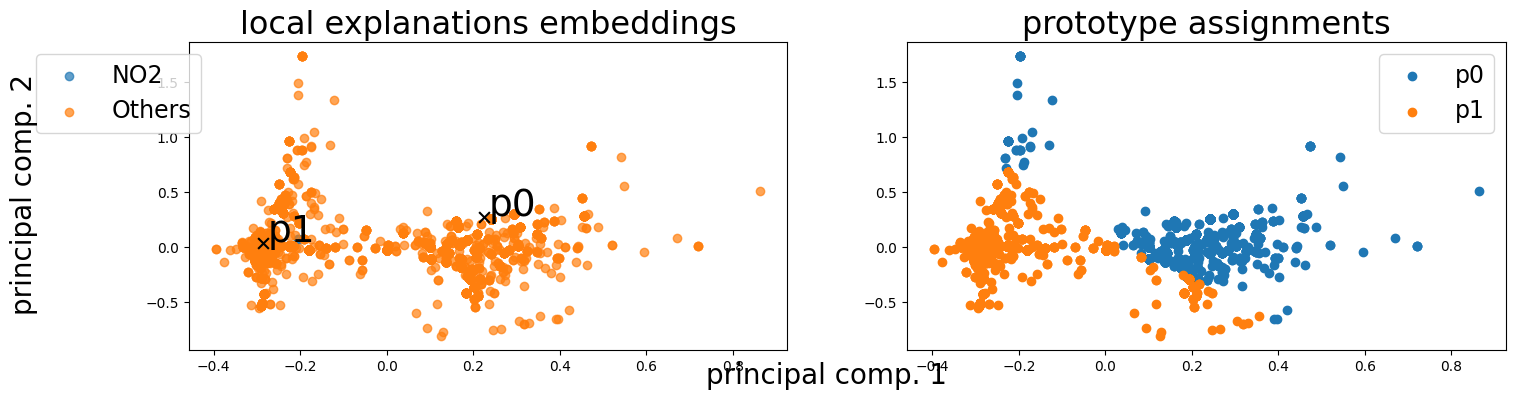

Alpha norms:
tensor([[1.0000, 0.5498],
        [1.0000, 0.5372]])
Concept Purity: 0.999663 +- 0.000337
Concept distribution:  (array([0, 1]), array([2959, 2964]))
Logic formulas:
For class 0:
0.6428785607196402 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6428785607196402 ((feature0000000001)
Accuracy as classifier:  0.6429
LEN fidelity:  tensor(0.6429)


140 | Train Acc: 0.64, Train Loss: 0.04754, Train LEN loss: 0.047409, | Val Acc: 0.67, Val Loss: 0.05336, Val LEN loss: 0.053
141 | Train Acc: 0.64, Train Loss: 0.04759, Train LEN loss: 0.047330, | Val Acc: 0.67, Val Loss: 0.05424, Val LEN loss: 0.054
142 | Train Acc: 0.64, Train Loss: 0.04754, Train LEN loss: 0.047409, | Val Acc: 0.65, Val Loss: 0.05445, Val LEN loss: 0.054
143 | Train Acc: 0.63, Train Loss: 0.04780, Train LEN loss: 0.047716, | Val Acc: 0.67, Val Loss: 0.05404, Val LEN loss: 0.054
144 | Train Acc: 0.64, Train Loss: 0.04752, Train LEN loss: 0.047411, | Val Acc: 0.67, Val Loss: 0.05367,

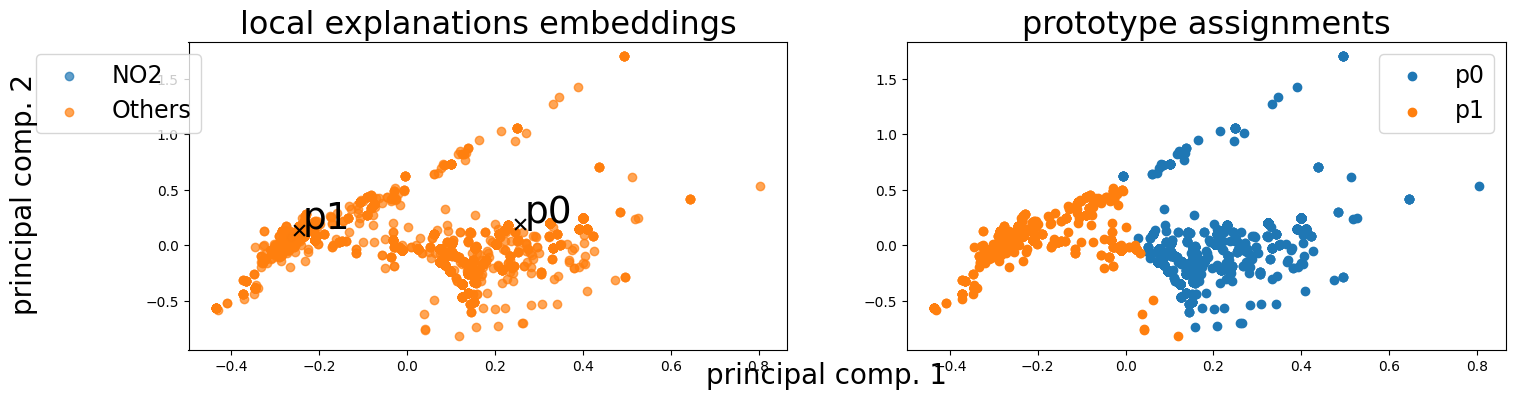

Alpha norms:
tensor([[1.0000, 0.5606],
        [1.0000, 0.5389]])
Concept Purity: 0.999631 +- 0.000369
Concept distribution:  (array([0, 1]), array([3215, 2708]))
Logic formulas:
For class 0:
0.6425787106446776 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6425787106446776 ((feature0000000001)
Accuracy as classifier:  0.6426
LEN fidelity:  tensor(0.6426)


160 | Train Acc: 0.64, Train Loss: 0.04722, Train LEN loss: 0.047132, | Val Acc: 0.66, Val Loss: 0.05386, Val LEN loss: 0.054
161 | Train Acc: 0.65, Train Loss: 0.04699, Train LEN loss: 0.046906, | Val Acc: 0.67, Val Loss: 0.05381, Val LEN loss: 0.054
162 | Train Acc: 0.64, Train Loss: 0.04731, Train LEN loss: 0.047174, | Val Acc: 0.67, Val Loss: 0.05411, Val LEN loss: 0.054
163 | Train Acc: 0.64, Train Loss: 0.04723, Train LEN loss: 0.047114, | Val Acc: 0.67, Val Loss: 0.05324, Val LEN loss: 0.053
164 | Train Acc: 0.64, Train Loss: 0.04745, Train LEN loss: 0.047382, | Val Acc: 0.66, Val Loss: 0.05427,

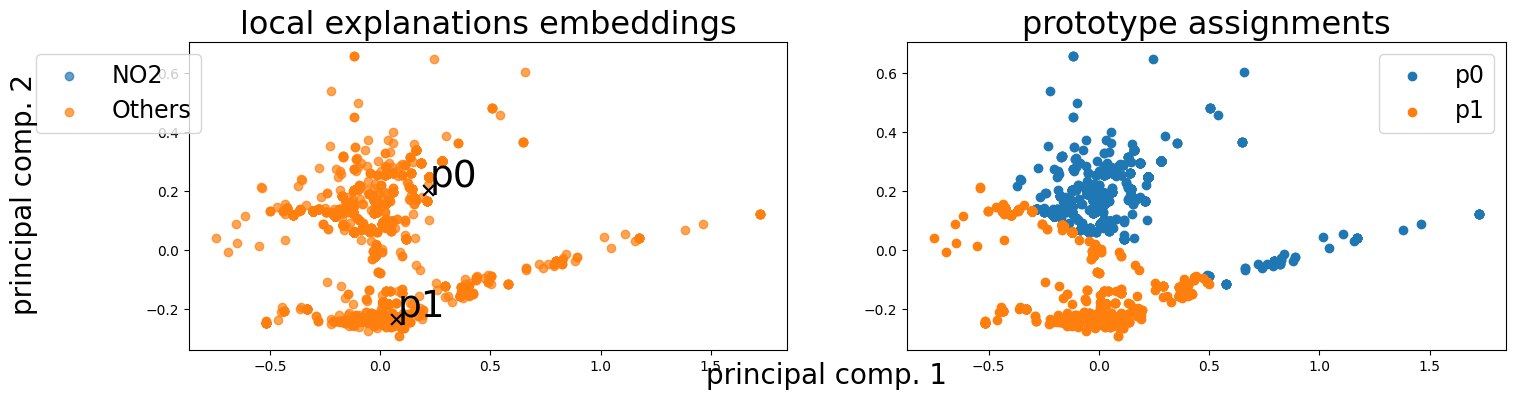

Alpha norms:
tensor([[1.0000, 0.5561],
        [1.0000, 0.5219]])
Concept Purity: 0.999683 +- 0.000317
Concept distribution:  (array([0, 1]), array([2767, 3156]))
Logic formulas:
For class 0:
0.6392803598200899 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6392803598200899 ((feature0000000001)
Accuracy as classifier:  0.6393
LEN fidelity:  tensor(0.6393)


180 | Train Acc: 0.65, Train Loss: 0.04681, Train LEN loss: 0.046723, | Val Acc: 0.67, Val Loss: 0.05357, Val LEN loss: 0.053
181 | Train Acc: 0.64, Train Loss: 0.04745, Train LEN loss: 0.047381, | Val Acc: 0.67, Val Loss: 0.05371, Val LEN loss: 0.054
182 | Train Acc: 0.64, Train Loss: 0.04755, Train LEN loss: 0.047490, | Val Acc: 0.66, Val Loss: 0.05393, Val LEN loss: 0.054
183 | Train Acc: 0.65, Train Loss: 0.04719, Train LEN loss: 0.047132, | Val Acc: 0.66, Val Loss: 0.05356, Val LEN loss: 0.053
184 | Train Acc: 0.65, Train Loss: 0.04763, Train LEN loss: 0.047566, | Val Acc: 0.68, Val Loss: 0.05381,

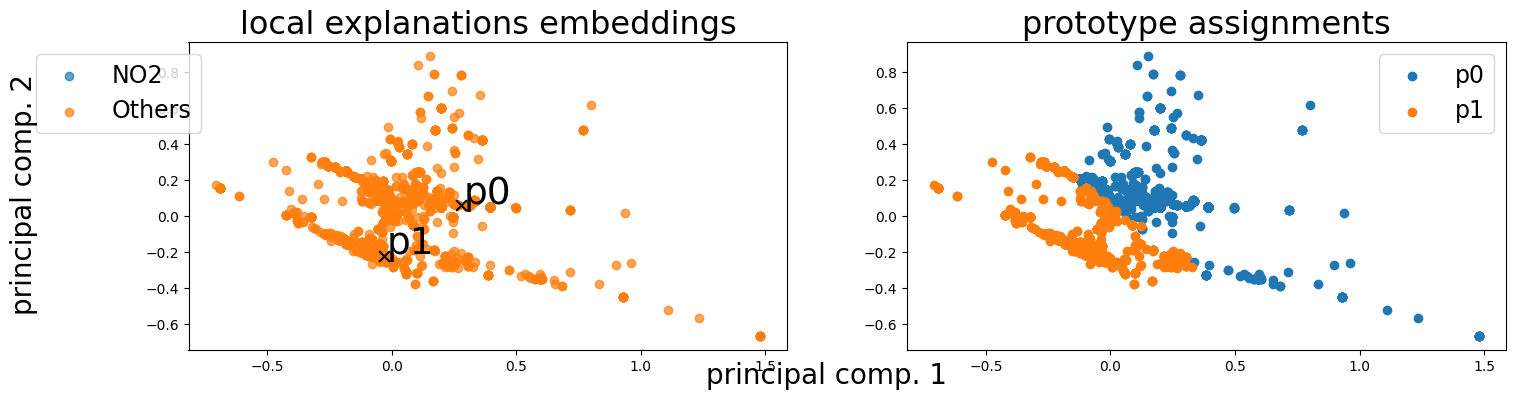

Alpha norms:
tensor([[1.0000, 0.5437],
        [1.0000, 0.5147]])
Concept Purity: 0.999717 +- 0.000283
Concept distribution:  (array([0, 1]), array([2389, 3534]))
Logic formulas:
For class 0:
0.6383808095952024 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6383808095952024 ((feature0000000001)
Accuracy as classifier:  0.6384
LEN fidelity:  tensor(0.6384)


200 | Train Acc: 0.64, Train Loss: 0.04687, Train LEN loss: 0.046805, | Val Acc: 0.68, Val Loss: 0.05291, Val LEN loss: 0.053
201 | Train Acc: 0.64, Train Loss: 0.04694, Train LEN loss: 0.046839, | Val Acc: 0.66, Val Loss: 0.05461, Val LEN loss: 0.054
202 | Train Acc: 0.65, Train Loss: 0.04700, Train LEN loss: 0.046931, | Val Acc: 0.66, Val Loss: 0.05413, Val LEN loss: 0.054
203 | Train Acc: 0.65, Train Loss: 0.04690, Train LEN loss: 0.046842, | Val Acc: 0.67, Val Loss: 0.05391, Val LEN loss: 0.054
204 | Train Acc: 0.65, Train Loss: 0.04704, Train LEN loss: 0.046984, | Val Acc: 0.67, Val Loss: 0.05326,

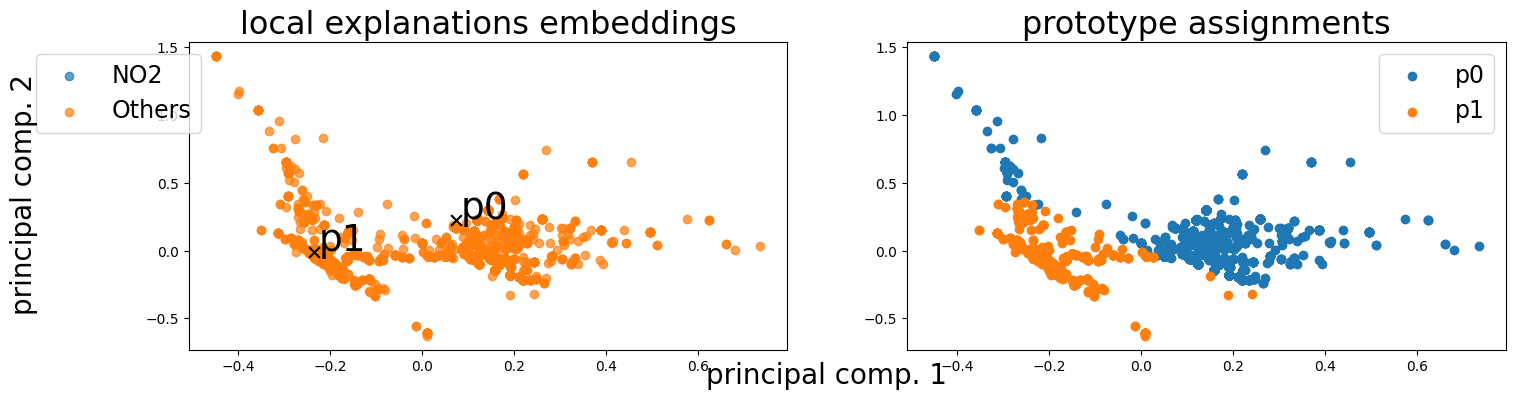

Alpha norms:
tensor([[1.0000, 0.5338],
        [1.0000, 0.5152]])
Concept Purity: 0.999612 +- 0.000388
Concept distribution:  (array([0, 1]), array([3347, 2576]))
Logic formulas:
For class 0:
0.6461769115442278 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6461769115442278 ((feature0000000001)
Accuracy as classifier:  0.6462
LEN fidelity:  tensor(0.6462)


220 | Train Acc: 0.64, Train Loss: 0.04687, Train LEN loss: 0.046817, | Val Acc: 0.67, Val Loss: 0.05328, Val LEN loss: 0.053
221 | Train Acc: 0.65, Train Loss: 0.04658, Train LEN loss: 0.046521, | Val Acc: 0.68, Val Loss: 0.05278, Val LEN loss: 0.053
222 | Train Acc: 0.64, Train Loss: 0.04711, Train LEN loss: 0.047065, | Val Acc: 0.68, Val Loss: 0.05321, Val LEN loss: 0.053
223 | Train Acc: 0.64, Train Loss: 0.04696, Train LEN loss: 0.046913, | Val Acc: 0.68, Val Loss: 0.05223, Val LEN loss: 0.052
224 | Train Acc: 0.64, Train Loss: 0.04736, Train LEN loss: 0.047302, | Val Acc: 0.65, Val Loss: 0.05440,

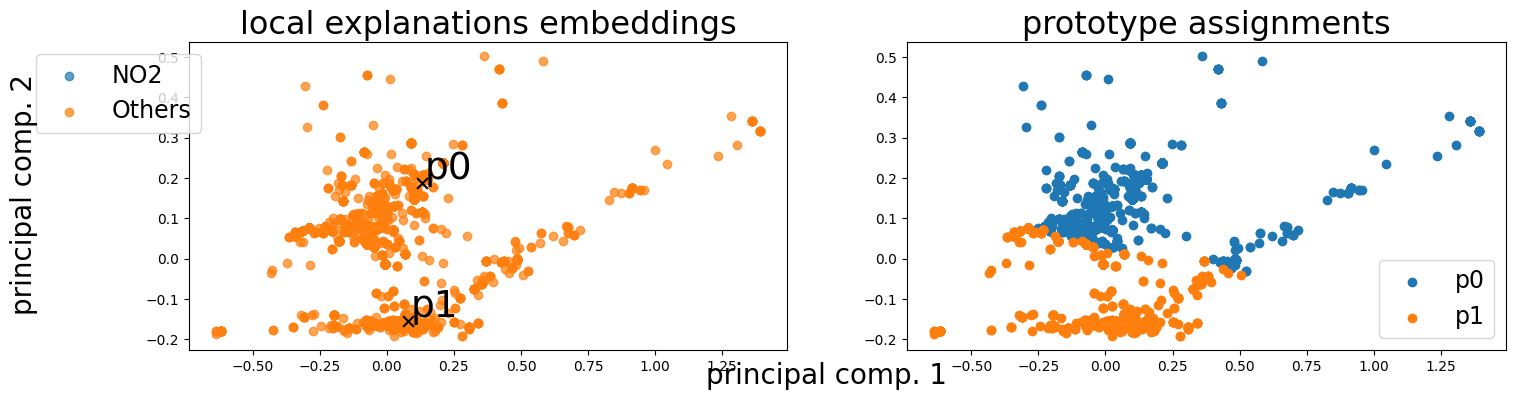

Alpha norms:
tensor([[1.0000, 0.5460],
        [1.0000, 0.4945]])
Concept Purity: 0.999697 +- 0.000303
Concept distribution:  (array([0, 1]), array([2624, 3299]))
Logic formulas:
For class 0:
0.6458770614692654 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6458770614692654 ((feature0000000001)
Accuracy as classifier:  0.6459
LEN fidelity:  tensor(0.6459)


240 | Train Acc: 0.65, Train Loss: 0.04678, Train LEN loss: 0.046723, | Val Acc: 0.68, Val Loss: 0.05290, Val LEN loss: 0.053
241 | Train Acc: 0.65, Train Loss: 0.04723, Train LEN loss: 0.047182, | Val Acc: 0.66, Val Loss: 0.05429, Val LEN loss: 0.054
242 | Train Acc: 0.65, Train Loss: 0.04719, Train LEN loss: 0.047135, | Val Acc: 0.69, Val Loss: 0.05221, Val LEN loss: 0.052
243 | Train Acc: 0.65, Train Loss: 0.04734, Train LEN loss: 0.047281, | Val Acc: 0.67, Val Loss: 0.05355, Val LEN loss: 0.053
244 | Train Acc: 0.65, Train Loss: 0.04692, Train LEN loss: 0.046853, | Val Acc: 0.67, Val Loss: 0.05377,

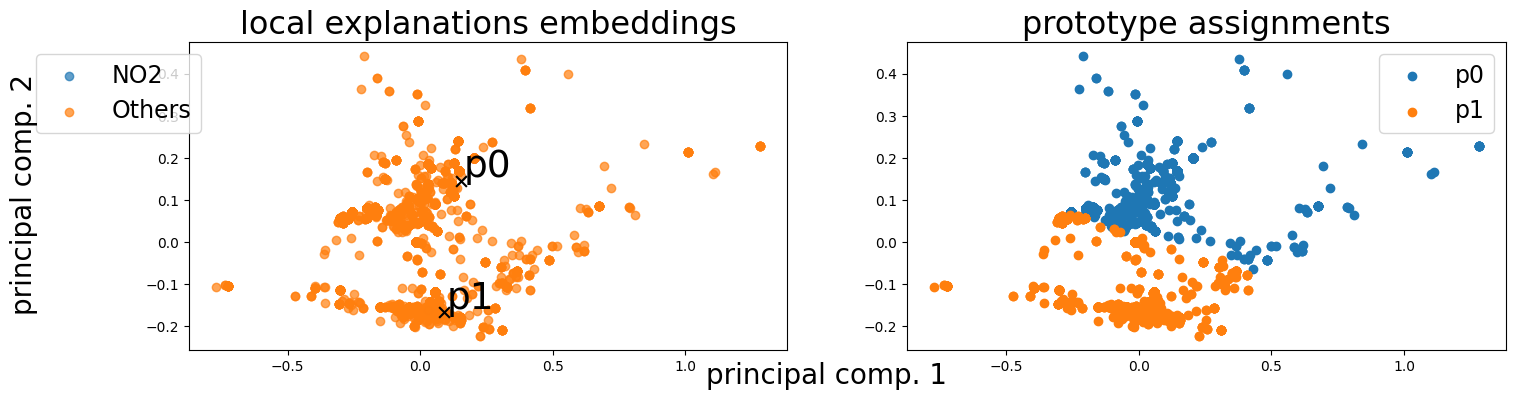

Alpha norms:
tensor([[1.0000, 0.5560],
        [1.0000, 0.4791]])
Concept Purity: 0.999629 +- 0.000371
Concept distribution:  (array([0, 1]), array([3227, 2696]))
Logic formulas:
For class 0:
0.6518740629685157 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6518740629685157 ((feature0000000001)
Accuracy as classifier:  0.6519
LEN fidelity:  tensor(0.6519)


260 | Train Acc: 0.65, Train Loss: 0.04718, Train LEN loss: 0.047128, | Val Acc: 0.68, Val Loss: 0.05318, Val LEN loss: 0.053
261 | Train Acc: 0.64, Train Loss: 0.04772, Train LEN loss: 0.047647, | Val Acc: 0.67, Val Loss: 0.05334, Val LEN loss: 0.053
262 | Train Acc: 0.63, Train Loss: 0.04736, Train LEN loss: 0.047291, | Val Acc: 0.67, Val Loss: 0.05387, Val LEN loss: 0.054
263 | Train Acc: 0.64, Train Loss: 0.04751, Train LEN loss: 0.047466, | Val Acc: 0.65, Val Loss: 0.05486, Val LEN loss: 0.055
264 | Train Acc: 0.65, Train Loss: 0.04675, Train LEN loss: 0.046697, | Val Acc: 0.66, Val Loss: 0.05352,

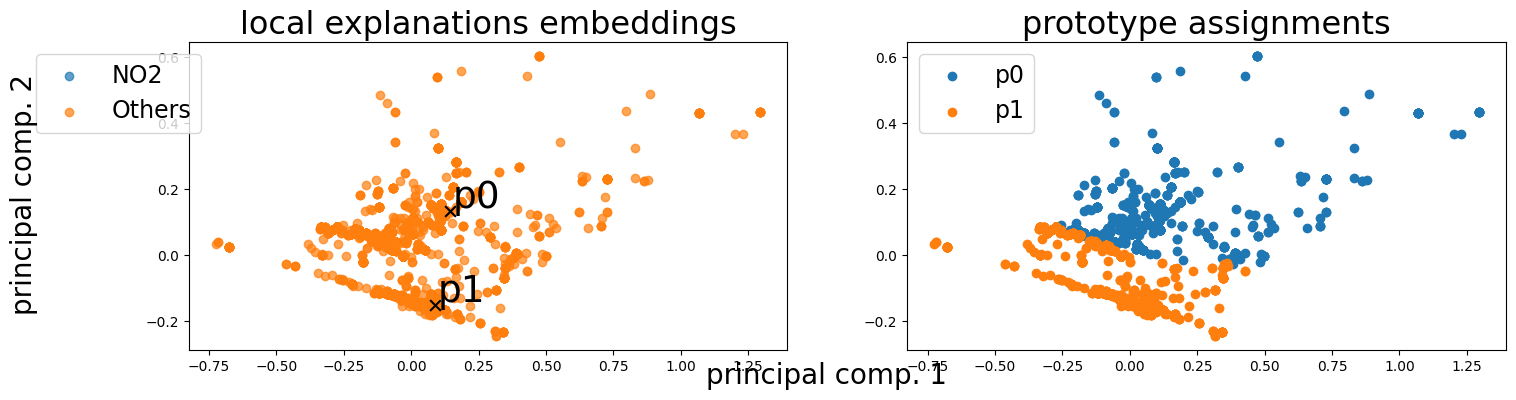

Alpha norms:
tensor([[1.0000, 0.5391],
        [1.0000, 0.5018]])
Concept Purity: 0.999697 +- 0.000303
Concept distribution:  (array([0, 1]), array([2620, 3303]))
Logic formulas:
For class 0:
0.6470764617691155 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6470764617691155 ((feature0000000001)
Accuracy as classifier:  0.6471
LEN fidelity:  tensor(0.6471)


280 | Train Acc: 0.65, Train Loss: 0.04682, Train LEN loss: 0.046774, | Val Acc: 0.69, Val Loss: 0.05257, Val LEN loss: 0.052
281 | Train Acc: 0.65, Train Loss: 0.04683, Train LEN loss: 0.046791, | Val Acc: 0.67, Val Loss: 0.05396, Val LEN loss: 0.054
282 | Train Acc: 0.65, Train Loss: 0.04674, Train LEN loss: 0.046687, | Val Acc: 0.67, Val Loss: 0.05393, Val LEN loss: 0.054
283 | Train Acc: 0.65, Train Loss: 0.04725, Train LEN loss: 0.047209, | Val Acc: 0.68, Val Loss: 0.05304, Val LEN loss: 0.053
284 | Train Acc: 0.65, Train Loss: 0.04653, Train LEN loss: 0.046477, | Val Acc: 0.69, Val Loss: 0.05256,

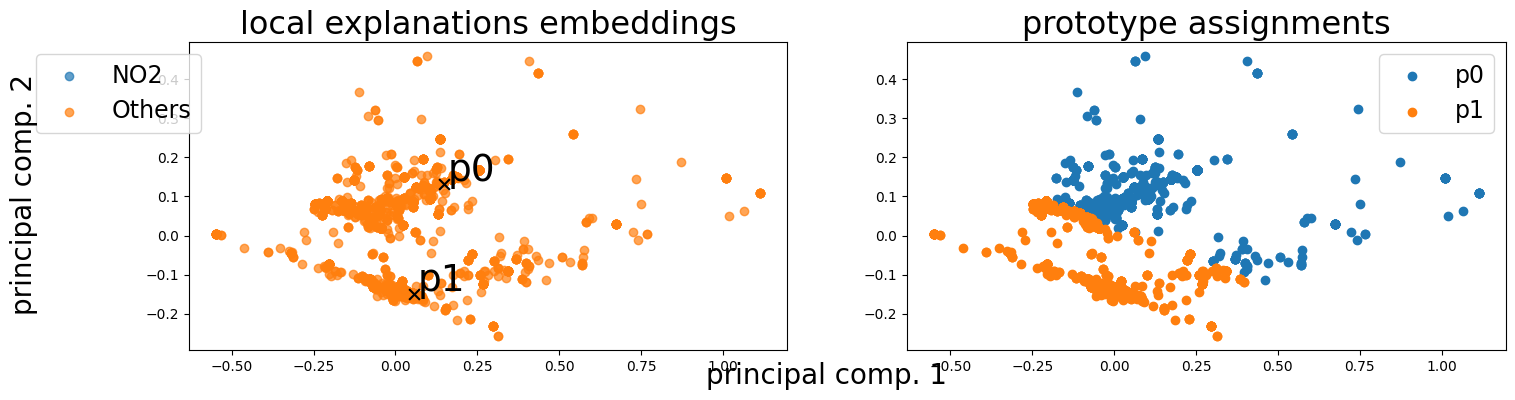

Alpha norms:
tensor([[1.0000, 0.5210],
        [1.0000, 0.4827]])
Concept Purity: 0.999704 +- 0.000296
Concept distribution:  (array([0, 1]), array([2542, 3381]))
Logic formulas:
For class 0:
0.6446776611694153 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6446776611694153 ((feature0000000001)
Accuracy as classifier:  0.6447
LEN fidelity:  tensor(0.6447)


300 | Train Acc: 0.65, Train Loss: 0.04688, Train LEN loss: 0.046840, | Val Acc: 0.69, Val Loss: 0.05298, Val LEN loss: 0.053
301 | Train Acc: 0.65, Train Loss: 0.04720, Train LEN loss: 0.047144, | Val Acc: 0.69, Val Loss: 0.05239, Val LEN loss: 0.052
302 | Train Acc: 0.65, Train Loss: 0.04687, Train LEN loss: 0.046832, | Val Acc: 0.68, Val Loss: 0.05322, Val LEN loss: 0.053
303 | Train Acc: 0.65, Train Loss: 0.04697, Train LEN loss: 0.046946, | Val Acc: 0.69, Val Loss: 0.05265, Val LEN loss: 0.053
304 | Train Acc: 0.64, Train Loss: 0.04689, Train LEN loss: 0.046851, | Val Acc: 0.68, Val Loss: 0.05345,

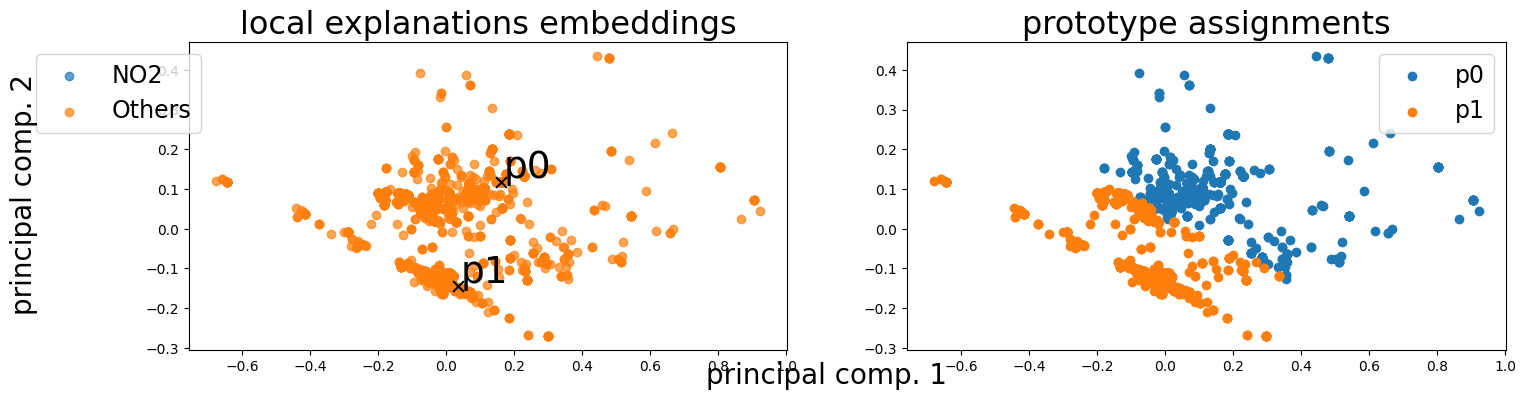

Alpha norms:
tensor([[1.0000, 0.5314],
        [1.0000, 0.4900]])
Concept Purity: 0.999756 +- 0.000244
Concept distribution:  (array([0, 1]), array([1826, 4097]))
Logic formulas:
For class 0:
0.6395802098950525 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6395802098950525 ((feature0000000001)
Accuracy as classifier:  0.6396
LEN fidelity:  tensor(0.6396)


320 | Train Acc: 0.66, Train Loss: 0.04690, Train LEN loss: 0.046861, | Val Acc: 0.67, Val Loss: 0.05276, Val LEN loss: 0.053
321 | Train Acc: 0.65, Train Loss: 0.04688, Train LEN loss: 0.046848, | Val Acc: 0.68, Val Loss: 0.05265, Val LEN loss: 0.053
322 | Train Acc: 0.65, Train Loss: 0.04693, Train LEN loss: 0.046901, | Val Acc: 0.68, Val Loss: 0.05382, Val LEN loss: 0.054
323 | Train Acc: 0.64, Train Loss: 0.04707, Train LEN loss: 0.047041, | Val Acc: 0.67, Val Loss: 0.05367, Val LEN loss: 0.054
324 | Train Acc: 0.64, Train Loss: 0.04751, Train LEN loss: 0.047477, | Val Acc: 0.67, Val Loss: 0.05414,

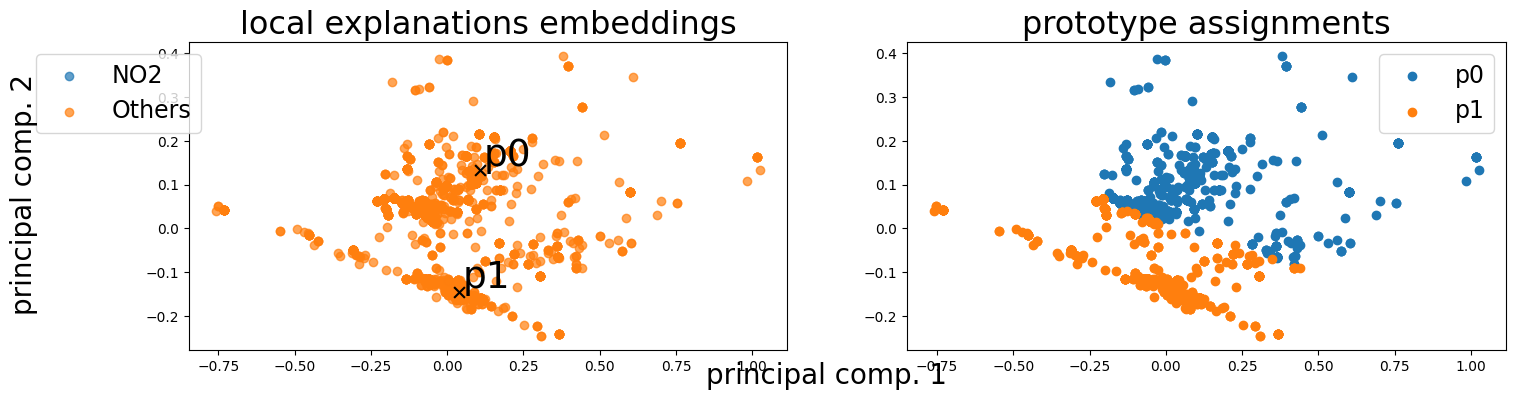

Alpha norms:
tensor([[1.0000, 0.5295],
        [1.0000, 0.4853]])
Concept Purity: 0.999654 +- 0.000346
Concept distribution:  (array([0, 1]), array([3030, 2893]))
Logic formulas:
For class 0:
0.6491754122938531 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6491754122938531 ((feature0000000001)
Accuracy as classifier:  0.6492
LEN fidelity:  tensor(0.6492)


340 | Train Acc: 0.65, Train Loss: 0.04714, Train LEN loss: 0.047105, | Val Acc: 0.67, Val Loss: 0.05305, Val LEN loss: 0.053
341 | Train Acc: 0.65, Train Loss: 0.04742, Train LEN loss: 0.047384, | Val Acc: 0.68, Val Loss: 0.05321, Val LEN loss: 0.053
342 | Train Acc: 0.64, Train Loss: 0.04775, Train LEN loss: 0.047700, | Val Acc: 0.66, Val Loss: 0.05367, Val LEN loss: 0.054
343 | Train Acc: 0.65, Train Loss: 0.04699, Train LEN loss: 0.046947, | Val Acc: 0.69, Val Loss: 0.05248, Val LEN loss: 0.052
344 | Train Acc: 0.66, Train Loss: 0.04713, Train LEN loss: 0.047097, | Val Acc: 0.68, Val Loss: 0.05310,

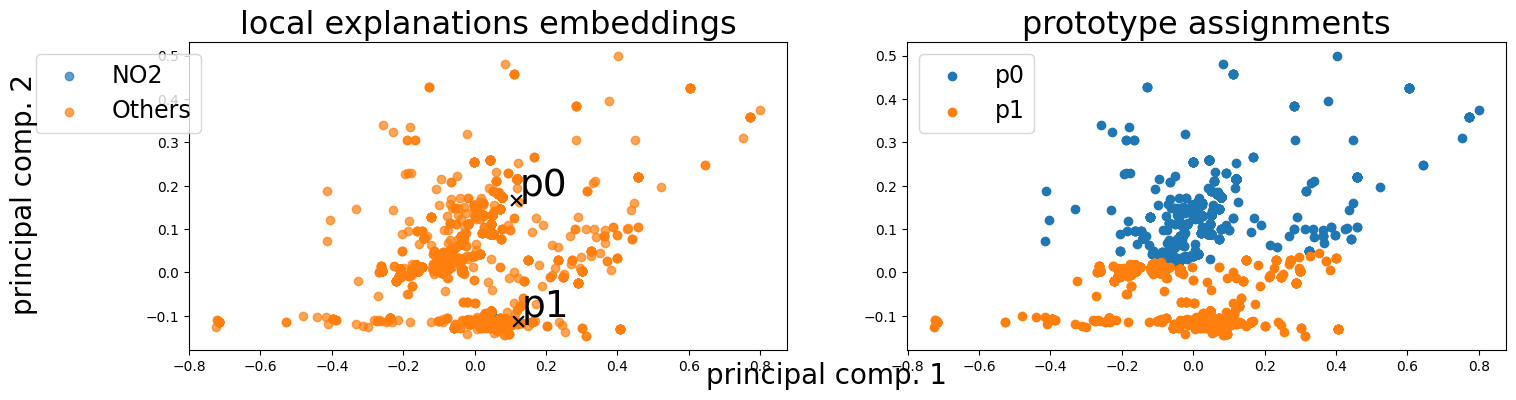

Alpha norms:
tensor([[1.0000, 0.4877],
        [1.0000, 0.4695]])
Concept Purity: 0.999756 +- 0.000244
Concept distribution:  (array([0, 1]), array([1817, 4106]))
Logic formulas:
For class 0:
0.6356821589205397 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6356821589205397 ((feature0000000001)
Accuracy as classifier:  0.6357
LEN fidelity:  tensor(0.6357)


360 | Train Acc: 0.65, Train Loss: 0.04716, Train LEN loss: 0.047110, | Val Acc: 0.67, Val Loss: 0.05326, Val LEN loss: 0.053
361 | Train Acc: 0.65, Train Loss: 0.04642, Train LEN loss: 0.046389, | Val Acc: 0.68, Val Loss: 0.05334, Val LEN loss: 0.053
362 | Train Acc: 0.65, Train Loss: 0.04703, Train LEN loss: 0.046996, | Val Acc: 0.69, Val Loss: 0.05212, Val LEN loss: 0.052
363 | Train Acc: 0.65, Train Loss: 0.04646, Train LEN loss: 0.046427, | Val Acc: 0.67, Val Loss: 0.05377, Val LEN loss: 0.054
364 | Train Acc: 0.64, Train Loss: 0.04684, Train LEN loss: 0.046801, | Val Acc: 0.68, Val Loss: 0.05234,

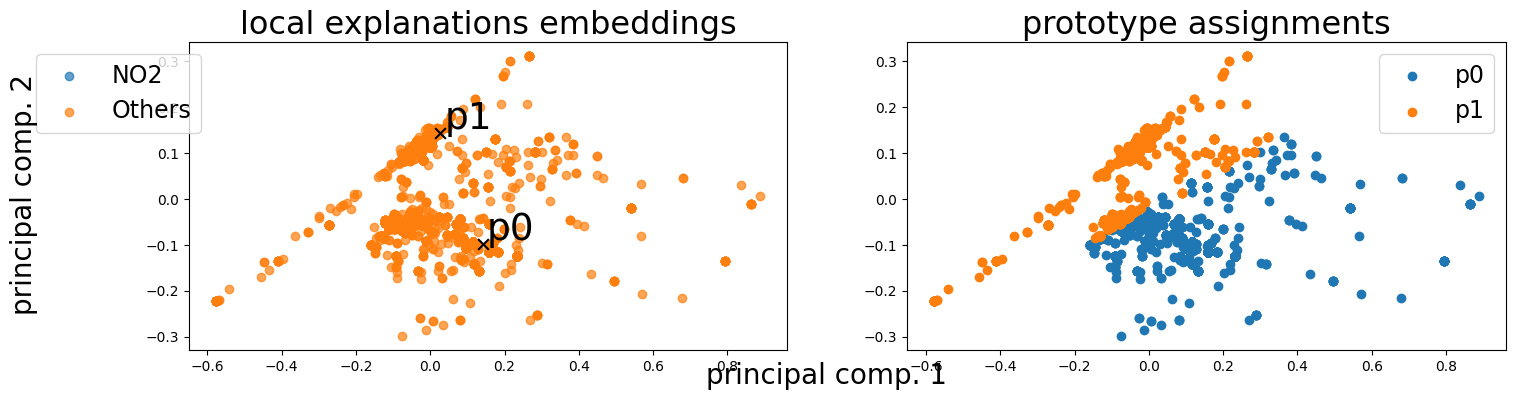

Alpha norms:
tensor([[1.0000, 0.5141],
        [1.0000, 0.4614]])
Concept Purity: 0.999698 +- 0.000302
Concept distribution:  (array([0, 1]), array([2614, 3309]))
Logic formulas:
For class 0:
0.6446776611694153 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6446776611694153 ((feature0000000001)
Accuracy as classifier:  0.6447
LEN fidelity:  tensor(0.6447)


380 | Train Acc: 0.65, Train Loss: 0.04709, Train LEN loss: 0.047057, | Val Acc: 0.70, Val Loss: 0.05185, Val LEN loss: 0.052
381 | Train Acc: 0.65, Train Loss: 0.04667, Train LEN loss: 0.046650, | Val Acc: 0.69, Val Loss: 0.05175, Val LEN loss: 0.052
382 | Train Acc: 0.65, Train Loss: 0.04658, Train LEN loss: 0.046525, | Val Acc: 0.69, Val Loss: 0.05269, Val LEN loss: 0.053
383 | Train Acc: 0.65, Train Loss: 0.04703, Train LEN loss: 0.047008, | Val Acc: 0.67, Val Loss: 0.05318, Val LEN loss: 0.053
384 | Train Acc: 0.65, Train Loss: 0.04677, Train LEN loss: 0.046736, | Val Acc: 0.68, Val Loss: 0.05289,

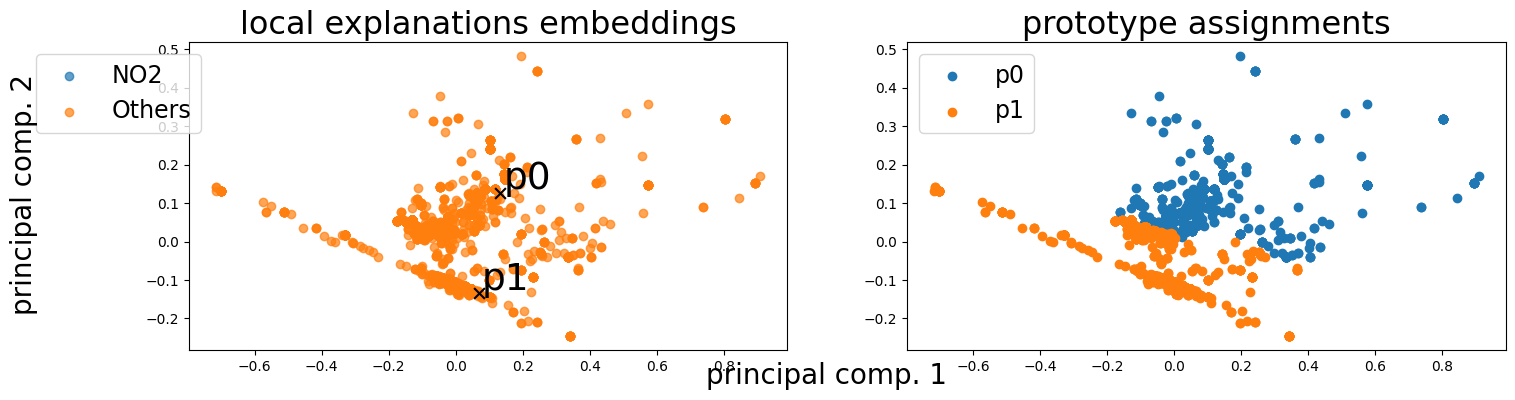

Alpha norms:
tensor([[1.0000, 0.5049],
        [1.0000, 0.4470]])
Concept Purity: 0.999755 +- 0.000245
Concept distribution:  (array([0, 1]), array([1842, 4081]))
Logic formulas:
For class 0:
0.6350824587706146 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6350824587706146 ((feature0000000001)
Accuracy as classifier:  0.6351
LEN fidelity:  tensor(0.6351)


400 | Train Acc: 0.65, Train Loss: 0.04660, Train LEN loss: 0.046576, | Val Acc: 0.67, Val Loss: 0.05338, Val LEN loss: 0.053
401 | Train Acc: 0.65, Train Loss: 0.04728, Train LEN loss: 0.047245, | Val Acc: 0.67, Val Loss: 0.05322, Val LEN loss: 0.053
402 | Train Acc: 0.65, Train Loss: 0.04713, Train LEN loss: 0.047098, | Val Acc: 0.68, Val Loss: 0.05277, Val LEN loss: 0.053
403 | Train Acc: 0.65, Train Loss: 0.04679, Train LEN loss: 0.046759, | Val Acc: 0.67, Val Loss: 0.05371, Val LEN loss: 0.054
404 | Train Acc: 0.65, Train Loss: 0.04728, Train LEN loss: 0.047244, | Val Acc: 0.67, Val Loss: 0.05383,

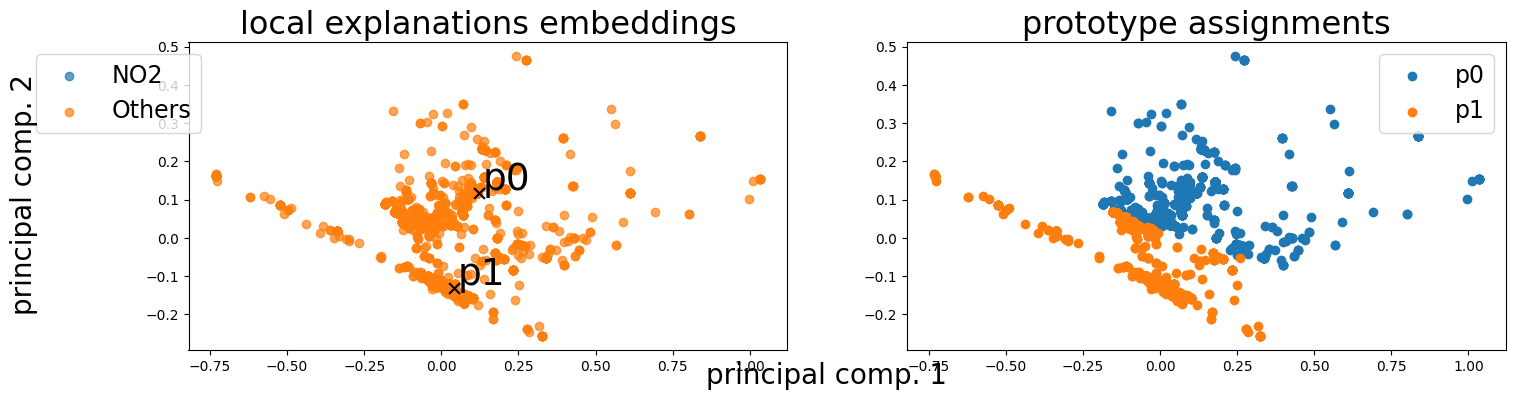

Alpha norms:
tensor([[1.0000, 0.5259],
        [1.0000, 0.4542]])
Concept Purity: 0.999732 +- 0.000268
Concept distribution:  (array([0, 1]), array([2188, 3735]))
Logic formulas:
For class 0:
0.6488755622188905 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6488755622188905 ((feature0000000001)
Accuracy as classifier:  0.6489
LEN fidelity:  tensor(0.6489)


420 | Train Acc: 0.66, Train Loss: 0.04664, Train LEN loss: 0.046613, | Val Acc: 0.68, Val Loss: 0.05335, Val LEN loss: 0.053
421 | Train Acc: 0.65, Train Loss: 0.04703, Train LEN loss: 0.046995, | Val Acc: 0.66, Val Loss: 0.05343, Val LEN loss: 0.053
422 | Train Acc: 0.64, Train Loss: 0.04679, Train LEN loss: 0.046758, | Val Acc: 0.69, Val Loss: 0.05269, Val LEN loss: 0.053
423 | Train Acc: 0.65, Train Loss: 0.04690, Train LEN loss: 0.046870, | Val Acc: 0.67, Val Loss: 0.05417, Val LEN loss: 0.054
424 | Train Acc: 0.65, Train Loss: 0.04722, Train LEN loss: 0.047193, | Val Acc: 0.68, Val Loss: 0.05269,

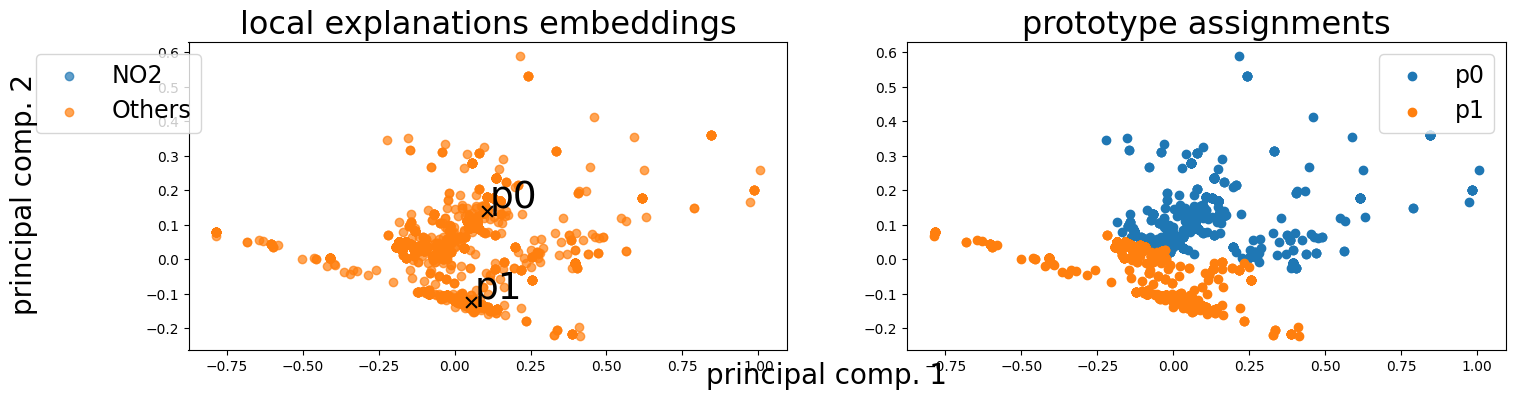

Alpha norms:
tensor([[1.0000, 0.5123],
        [1.0000, 0.4364]])
Concept Purity: 0.999754 +- 0.000246
Concept distribution:  (array([0, 1]), array([1854, 4069]))
Logic formulas:
For class 0:
0.6383808095952024 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6383808095952024 ((feature0000000001)
Accuracy as classifier:  0.6384
LEN fidelity:  tensor(0.6384)


440 | Train Acc: 0.65, Train Loss: 0.04719, Train LEN loss: 0.047160, | Val Acc: 0.67, Val Loss: 0.05350, Val LEN loss: 0.053
441 | Train Acc: 0.65, Train Loss: 0.04682, Train LEN loss: 0.046765, | Val Acc: 0.67, Val Loss: 0.05279, Val LEN loss: 0.053
442 | Train Acc: 0.65, Train Loss: 0.04710, Train LEN loss: 0.047075, | Val Acc: 0.67, Val Loss: 0.05362, Val LEN loss: 0.054
443 | Train Acc: 0.65, Train Loss: 0.04659, Train LEN loss: 0.046556, | Val Acc: 0.67, Val Loss: 0.05340, Val LEN loss: 0.053
444 | Train Acc: 0.66, Train Loss: 0.04686, Train LEN loss: 0.046835, | Val Acc: 0.67, Val Loss: 0.05396,

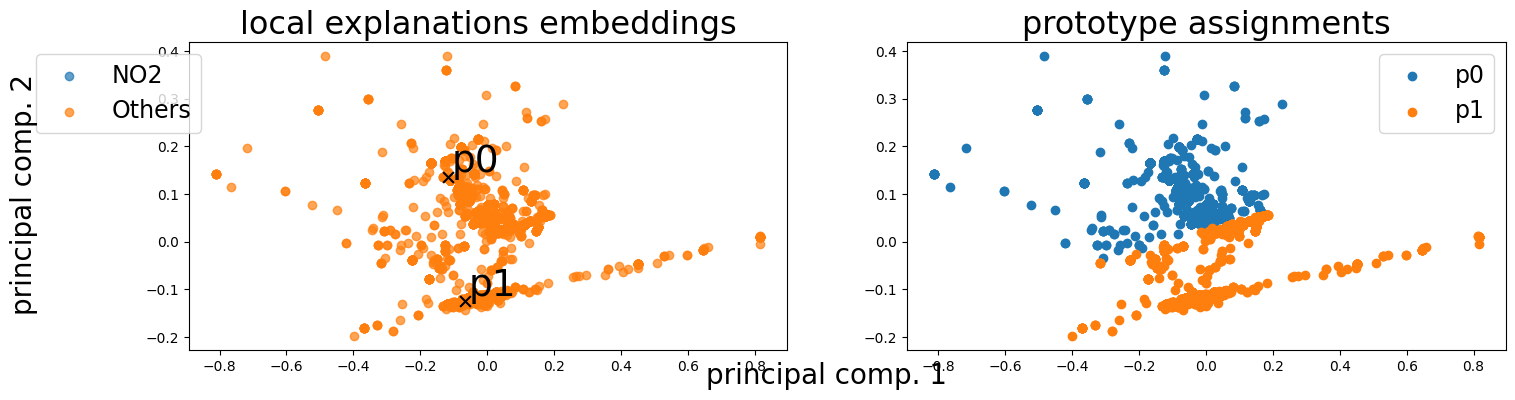

Alpha norms:
tensor([[1.0000, 0.5000],
        [1.0000, 0.4367]])
Concept Purity: 0.999746 +- 0.000254
Concept distribution:  (array([0, 1]), array([1979, 3944]))
Logic formulas:
For class 0:
0.6470764617691155 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6470764617691155 ((feature0000000001)
Accuracy as classifier:  0.6471
LEN fidelity:  tensor(0.6471)


460 | Train Acc: 0.65, Train Loss: 0.04694, Train LEN loss: 0.046902, | Val Acc: 0.68, Val Loss: 0.05262, Val LEN loss: 0.053
461 | Train Acc: 0.65, Train Loss: 0.04692, Train LEN loss: 0.046882, | Val Acc: 0.70, Val Loss: 0.05279, Val LEN loss: 0.053
462 | Train Acc: 0.65, Train Loss: 0.04692, Train LEN loss: 0.046881, | Val Acc: 0.67, Val Loss: 0.05255, Val LEN loss: 0.053
463 | Train Acc: 0.65, Train Loss: 0.04683, Train LEN loss: 0.046797, | Val Acc: 0.67, Val Loss: 0.05370, Val LEN loss: 0.054
464 | Train Acc: 0.66, Train Loss: 0.04684, Train LEN loss: 0.046815, | Val Acc: 0.67, Val Loss: 0.05401,

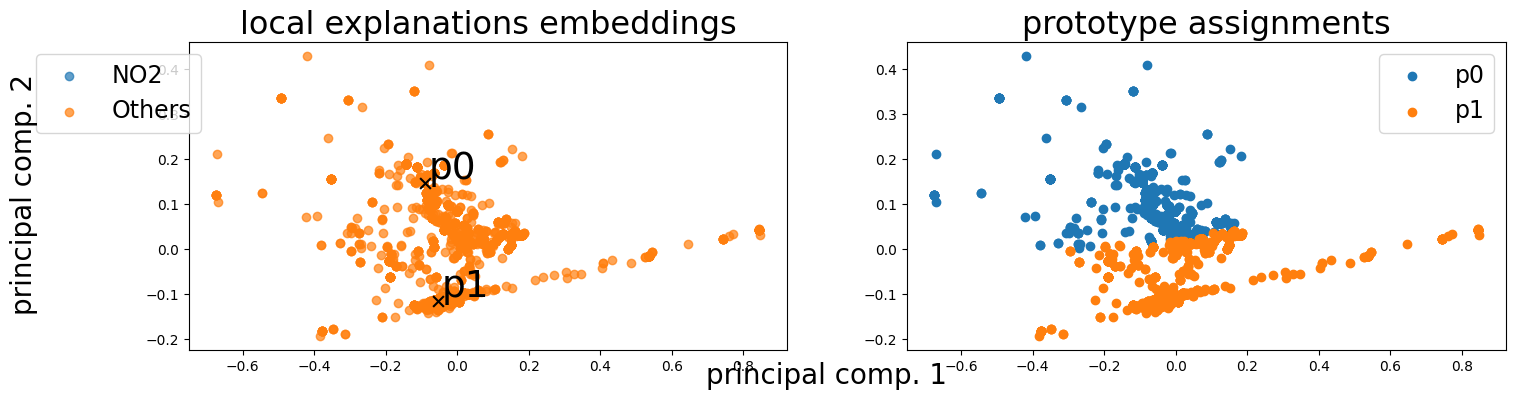

Alpha norms:
tensor([[1.0000, 0.5081],
        [1.0000, 0.4353]])
Concept Purity: 0.999757 +- 0.000243
Concept distribution:  (array([0, 1]), array([1801, 4122]))
Logic formulas:
For class 0:
0.6380809595202399 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6380809595202399 ((feature0000000001)
Accuracy as classifier:  0.6381
LEN fidelity:  tensor(0.6381)


480 | Train Acc: 0.65, Train Loss: 0.04697, Train LEN loss: 0.046938, | Val Acc: 0.67, Val Loss: 0.05379, Val LEN loss: 0.054
481 | Train Acc: 0.65, Train Loss: 0.04695, Train LEN loss: 0.046923, | Val Acc: 0.68, Val Loss: 0.05269, Val LEN loss: 0.053
482 | Train Acc: 0.65, Train Loss: 0.04698, Train LEN loss: 0.046950, | Val Acc: 0.70, Val Loss: 0.05266, Val LEN loss: 0.053
483 | Train Acc: 0.65, Train Loss: 0.04687, Train LEN loss: 0.046848, | Val Acc: 0.68, Val Loss: 0.05312, Val LEN loss: 0.053
484 | Train Acc: 0.65, Train Loss: 0.04689, Train LEN loss: 0.046862, | Val Acc: 0.67, Val Loss: 0.05439,

In [9]:
expl.iterate(train_group_loader, val_group_loader, plot=True)

(array([1.], dtype=float32), array([1478]))
[0.5193948 0.3290567]


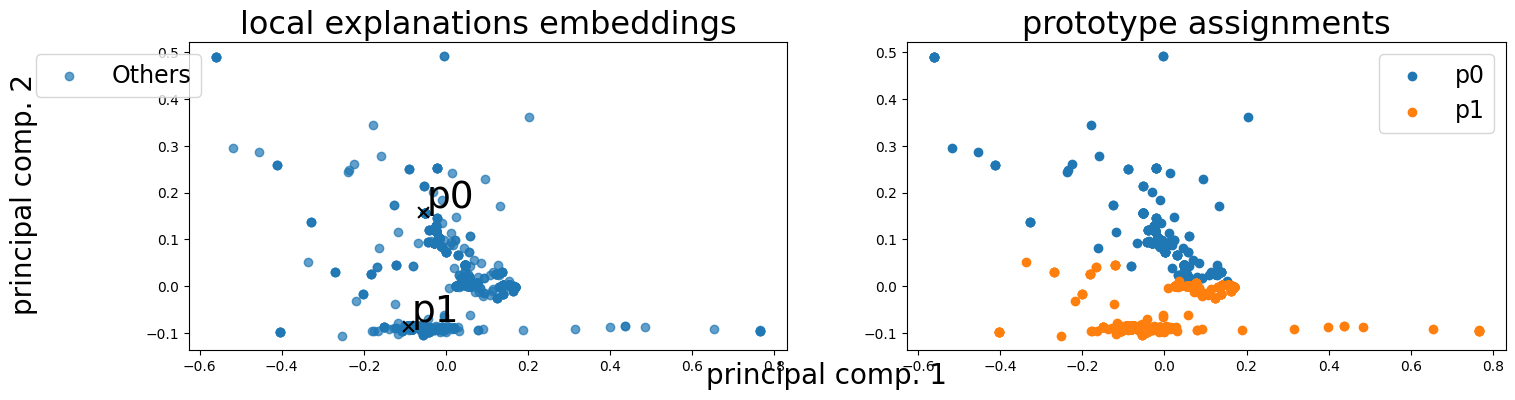

Alpha norms:
tensor([[1.0000, 0.4868],
        [1.0000, 0.4183]])
Concept Purity: 1.000000 +- 0.000000
Concept distribution:  (array([0, 1]), array([ 474, 1004]))
Logic formulas:
For class 0:
0.6670644391408115 (feature0000000000) | ((feature0000000001 & feature0000000000)
For class 1:
0.6670644391408115 ((feature0000000001)
Accuracy as classifier:  0.6671
LEN fidelity:  tensor(0.6671)



In [10]:
expl.inspect(test_group_loader, plot=True)

### Materialize Prototypes

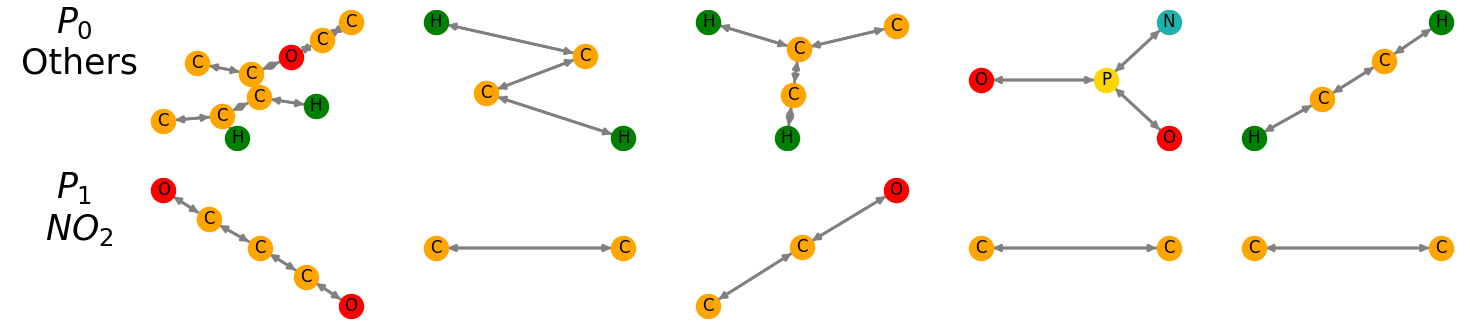

In [13]:
# change assign function to a non-discrete one just to compute distance between local expls. and prototypes
# useful to show the materialization of prototypes based on distance 
best_expl = expl
best_expl.hyper["assign_func"] = "sim"

(
    x_train,
    emb,
    concepts_assignement,
    y_train_1h,
    le_classes,
    le_idxs,
    belonging
) = best_expl.get_concept_vector(train_group_loader, return_raw=True)

best_expl.hyper["assign_func"] = "discrete"

proto_names = {
    0: "Non-mutagenic",
    1: "Mutagenic",
}

torch.manual_seed(42)

fig = plt.figure(figsize=(17,4))
n = 0
for p in range(best_expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))] # for random examples
    sa = concepts_assignement[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.argsort(sa[:, p], descending=True)]

    for ex in range(5):
        n += 1
        plt.subplot(best_expl.hyper["num_prototypes"],5,n)        
        utils.plot_molecule(dataset_train[int(idxs[ex])], composite_plot=True)

for p in range(best_expl.hyper["num_prototypes"]):
    plt.subplot(best_expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)

plt.show()

## Load Trained Model

/DATATWO/users/burouj/miniconda3/envs/glg/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


(array([0.], dtype=float32), array([139]))
[0.76503783 0.17528747]


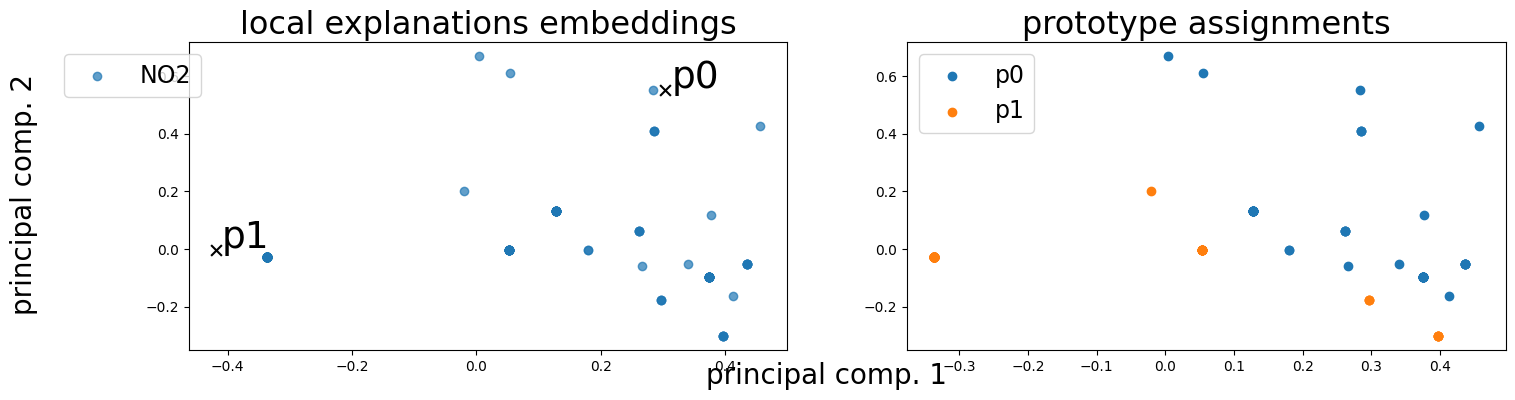

Alpha norms:
tensor([[1.0000, 0.6633],
        [1.0000, 0.5548]])
Concept Purity: 1.000000 +- 0.000000
Concept distribution:  (array([0, 1]), array([57, 82]))
Logic formulas:
For class 0:
0.826530612244898 ((feature0000000001) | ((feature0000000001 & feature0000000000)
For class 1:
0.826530612244898 (feature0000000000)
Accuracy as classifier:  0.8265
LEN fidelity:  tensor(0.8265)



In [8]:
train_group_loader = utils.build_dataloader(dataset_train, belonging_train, num_input_graphs=128)
val_group_loader   = utils.build_dataloader(dataset_val,   belonging_val,   num_input_graphs=256)
test_group_loader  = utils.build_dataloader(dataset_test,  belonging_test,  num_input_graphs=256)

torch.manual_seed(42)

len_model2 = models.LEN(
    hyper_params["num_prototypes"], 
    hyper_params["LEN_temperature"], 
    remove_attention=hyper_params["remove_attention"]
).to(device)

le_model2 = models.LEEmbedder(
    num_features=hyper_params["num_le_features"], 
    activation=hyper_params["activation"], 
    num_hidden=hyper_params["dim_prototypes"]
).to(device)

best_expl = models.GLGExplainer(
    len_model2, 
    le_model2, 
    device, 
    hyper_params=hyper_params,
    classes_names=mutag_classes_names,
    dataset_name=DATASET_NAME,
    num_classes=len(train_group_loader.dataset.data.task_y.unique())
).to(device)

best_expl.load_state_dict(torch.load(SAVE_GLG_MODEL_PATH))
best_expl.eval()

best_expl.inspect(test_group_loader)

### Materialize Prototypes

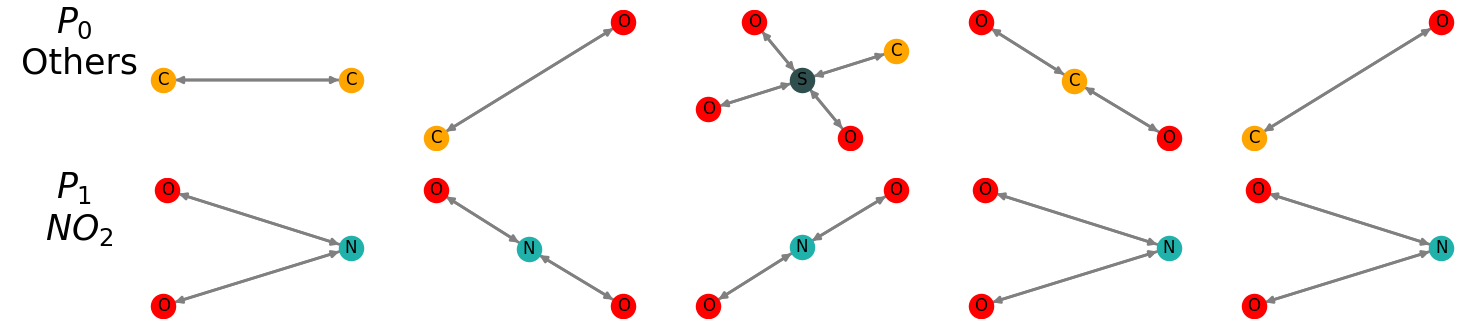

In [9]:
# change assign function to a non-discrete one just to compute distance between local expls. and prototypes
# useful to show the materialization of prototypes based on distance 
best_expl.hyper["assign_func"] = "sim"

(
    x_train,
    emb,
    concepts_assignement,
    y_train_1h,
    le_classes,
    le_idxs,
    belonging
) = best_expl.get_concept_vector(train_group_loader, return_raw=True)

best_expl.hyper["assign_func"] = "discrete"

proto_names = {
    0: "Others",
    1: "$NO_2$",
}

torch.manual_seed(42)

fig = plt.figure(figsize=(17,4))
n = 0
for p in range(best_expl.hyper["num_prototypes"]):
    idxs = le_idxs[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.randperm(len(idxs))] # for random examples
    sa = concepts_assignement[concepts_assignement.argmax(-1) == p]
    idxs = idxs[torch.argsort(sa[:, p], descending=True)]

    for ex in range(5):
        n += 1
        plt.subplot(best_expl.hyper["num_prototypes"],5,n)        
        utils.plot_molecule(dataset_train[int(idxs[ex])], composite_plot=True)

for p in range(best_expl.hyper["num_prototypes"]):
    plt.subplot(best_expl.hyper["num_prototypes"],5,5*p + 1)
    plt.ylabel(f"$P_{p}$\n {proto_names[p]}", size=25, rotation="horizontal", labelpad=50)

plt.show()